In [354]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [355]:
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

dirname = os.path.abspath(os.curdir) + r'\data'
df = pd.read_csv(path.join(os.sep, dirname, 'Annual snowfall in Chicago 1939 to 1978.csv'))
df = df['x']
df.head()

0    33.9
1    31.0
2    52.5
3    29.8
4    45.2
Name: x, dtype: float64

In [356]:
df.describe()

count    40.000000
mean     41.442500
std      15.714584
min      14.300000
25%      30.700000
50%      38.000000
75%      52.275000
max      82.300000
Name: x, dtype: float64

In [357]:
from statsmodels.tsa.stattools import adfuller

def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")
Fuller('Snowfall', df)

Тест Дики-Фуллера ряда Snowfall :
Test Statistic                -5.830728e+00
p-value                        3.980943e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


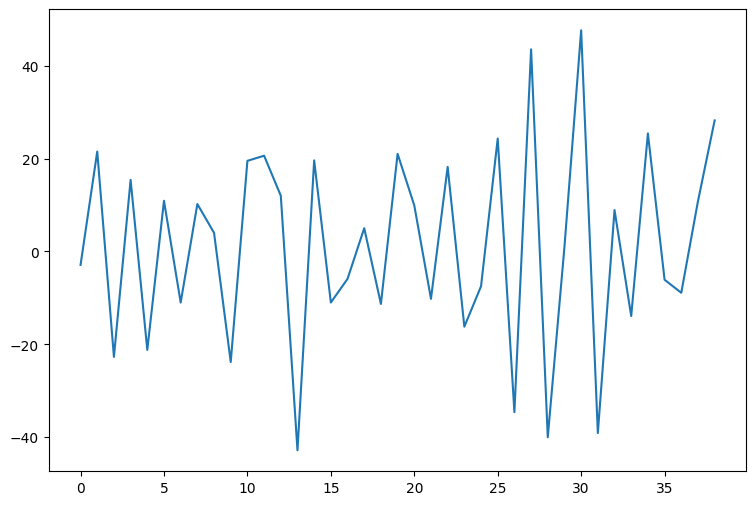

In [358]:
nottrend = []
s = 3
notseason = []

# выборка без тренда
for i in range(1, len(df)):
   nottrend.append(df[i] - df[i-1])

# выборка без сезонности
for i in range(s, len(df)):
   notseason.append(df[i] - df[i-s])
plt.plot(nottrend)

In [359]:
Fuller('Non Trend Snowfall', nottrend)

Тест Дики-Фуллера ряда Non Trend Snowfall :
Test Statistic                 -4.409734
p-value                         0.000285
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


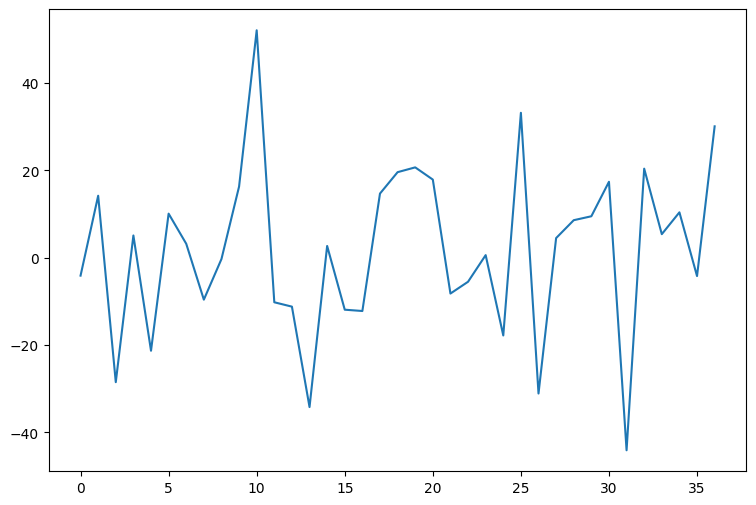

In [360]:
plt.plot(notseason)

In [361]:
Fuller('Non Season Snowfall', notseason)

Тест Дики-Фуллера ряда Non Season Snowfall :
Test Statistic                 -3.706161
p-value                         0.004027
#Lags Used                      6.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


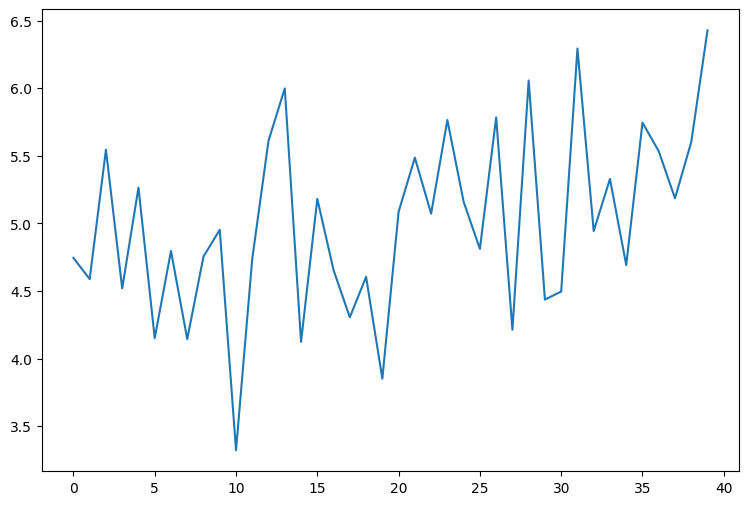

In [362]:
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(df)

plt.plot(transformed_data)

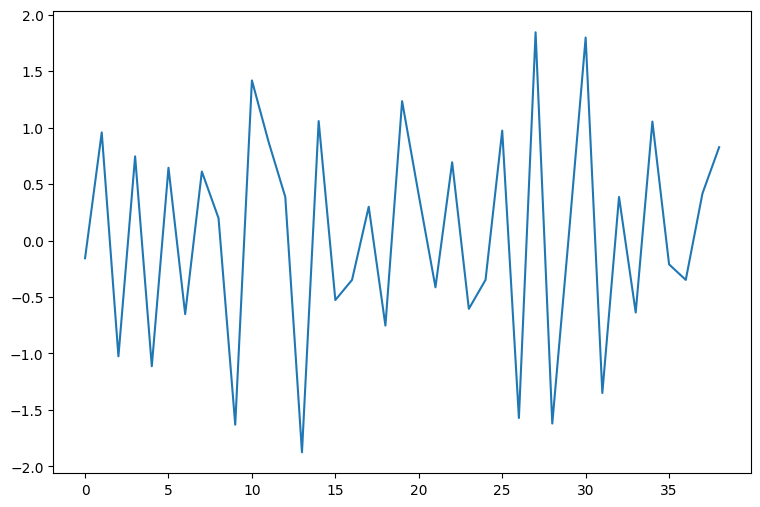

In [363]:
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend)

In [364]:
Fuller('BoxKox Snowfall', pnottrend)

Тест Дики-Фуллера ряда BoxKox Snowfall :
Test Statistic                 -4.394145
p-value                         0.000304
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


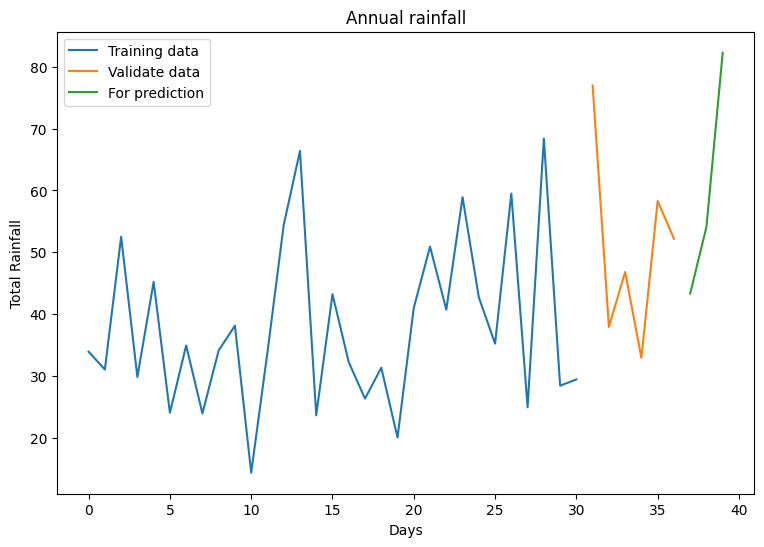

In [365]:
ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.title('Annual rainfall')
plt.ylabel('Total Rainfall')
plt.xlabel('Days')
plt.show()

In [366]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

mod = AutoReg(df, 3, old_names=False)
res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   40
Model:                     AutoReg(3)   Log Likelihood                -153.630
Method:               Conditional MLE   S.D. of innovations             15.382
Date:                Tue, 21 Nov 2023   AIC                            317.260
Time:                        17:23:24   BIC                            325.315
Sample:                             3   HQIC                           320.100
                                   40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4648     13.167      2.086      0.037       1.658      53.272
x.L1          -0.0546      0.177     -0.308      0.758      -0.402       0.293
x.L2           0.1815      0.178      1.018      0.3

In [367]:
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   40
Model:                     AutoReg(3)   Log Likelihood                -153.630
Method:               Conditional MLE   S.D. of innovations             15.382
Date:                Tue, 21 Nov 2023   AIC                            317.260
Time:                        17:23:24   BIC                            325.315
Sample:                             3   HQIC                           320.100
                                   40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4648     12.081      2.273      0.023       3.787      51.143
x.L1          -0.0546      0.163     -0.334      0.738      -0.375       0.265
x.L2           0.1815      0.154      1.182      0.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


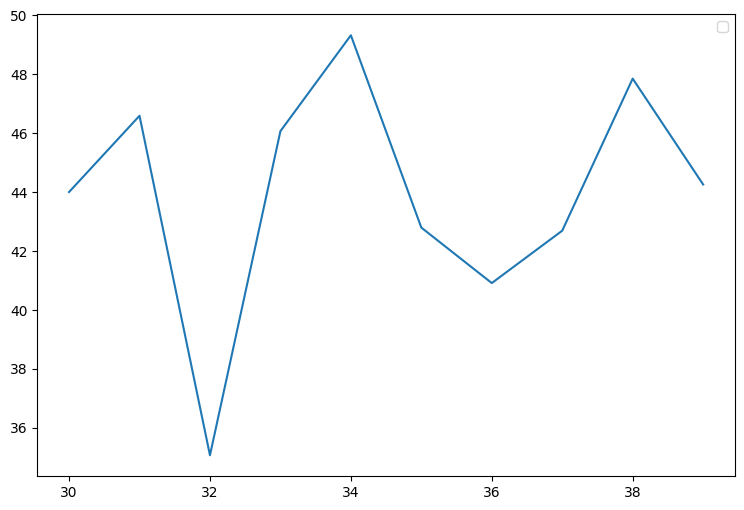

In [368]:
fig = res.plot_predict(train_cutoff)

In [369]:
len(df)

40

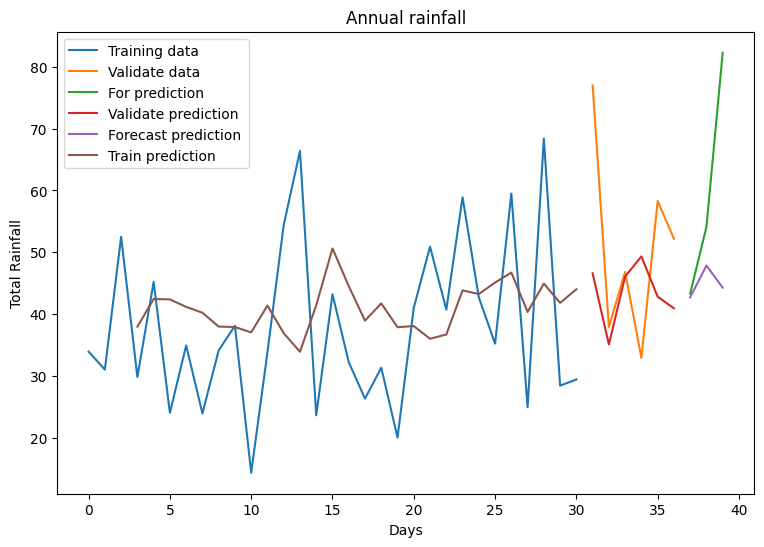

In [370]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(len(df)-1), dynamic=False)

plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.plot(validate_df.index, v_pred, label='Validate prediction ')
plt.plot(forecast_df.index, f_pred, label='Forecast prediction')
plt.plot(train_df.index, pred, label='Train prediction')

plt.legend()
plt.title('Annual rainfall')
plt.ylabel('Total Rainfall')
plt.xlabel('Days')
plt.show()

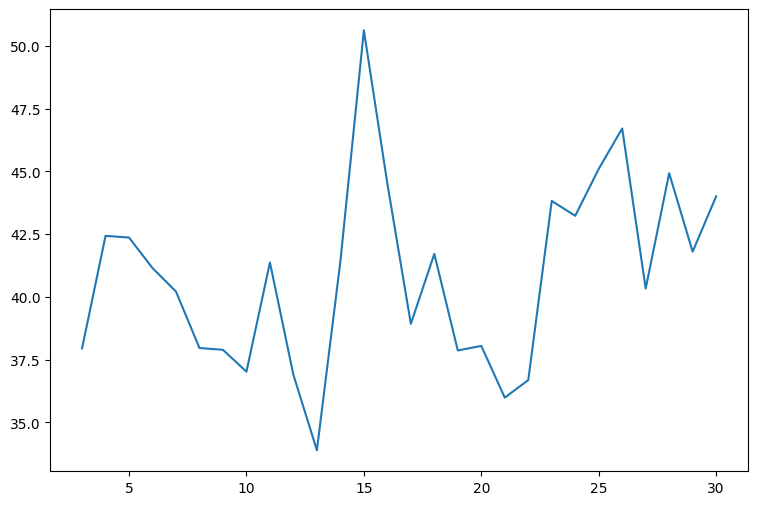

In [371]:
plt.plot(pred)

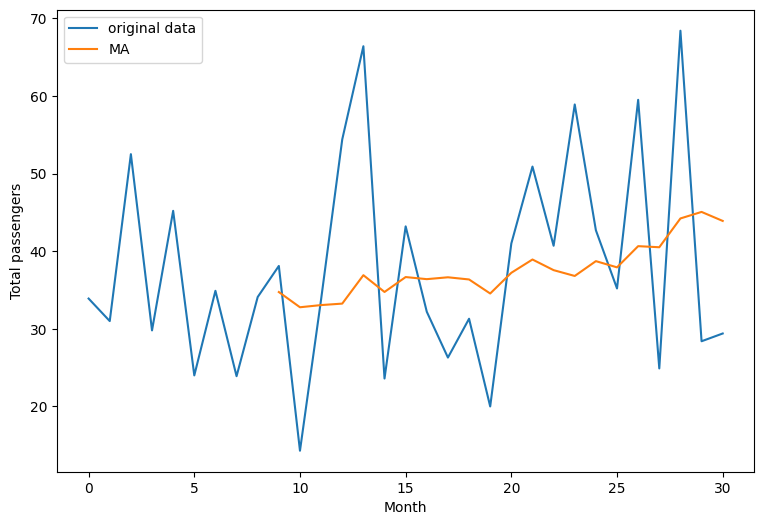

In [372]:
ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df.index <= train_cutoff]
validate_df = df[(df.index > train_cutoff) & (df.index <= validate_cutoff)]
forecast_df = df[df.index > validate_cutoff]

plt.plot(train_df.index, train_df, label="original data")
plt.plot(train_df.index, train_df.rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [373]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df, f_pred))
print("MAE:", mean_absolute_error(forecast_df, f_pred))
print("R2: ", r2_score(forecast_df, f_pred))